# ***화승***

## ***IMPORT LIBRARY***
---

In [1]:
### Library Import 
import os
import re
import sys
import glob
import shap
import optuna
import pickle
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
from math import ceil
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from functools import partial
from collections import Counter
from pandarallel import pandarallel
from xgboost import XGBRegressor, callback as xgb_callback
from datetime import timedelta, time, datetime
from scipy.stats import truncnorm
from IPython.display import Image
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
warnings.filterwarnings('ignore')
plt.rc('font', family='Apple SD Gothic Neo')

# Pandas 옵션 설정 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

# Scikit-Learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence 

# Import fns 
from utils import * 
from hwaseung_fn import * 

In [2]:
### Parameters 
path = '/Users/hwijongim/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm' 
p_type = 'FMB'

## ***Load Dataset***
---

In [3]:
### Load Raw Data 
# Data Import 
log_df, qa_df, recipe_df, info, weather_df = import_raw_data(path) 
log_df = get_cluster_p_codes(log_df, p_type) 
recipe_origin_df = recipe_df.copy() 

# Print 
print('='*100)
print(f'Log Dataset: {log_df.shape}')
print(f'QA Dataset: {qa_df.shape}')
print(f'Recipe Dataset: {recipe_df.shape}')
print(f'INFO Dataset: {info.shape}')
print(f'Weather Dataset: {weather_df.shape}')
print('='*100)

Log Dataset: (7036247, 37)
QA Dataset: (334291, 16)
Recipe Dataset: (1813072, 13)
INFO Dataset: (80, 2)
Weather Dataset: (1268, 5)


## ***Data Preprocessing***
---

In [4]:
### Log Dataset 정제 
log_df4, log_df5 = prep_log(log_df)

# Print 
print('='*100)
print(f'Log Dataset: {log_df4.shape}')
print(f'Log Train Dataset: {log_df5.shape}')
print('='*100)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Log Dataset: (6591541, 39)
Log Train Dataset: (101787, 18)


In [5]:
### QA Dataset 정제 
qa_df4, qa_df5 = prep_qa(qa_df)

# Print 
print('='*100)
print(f'Qa Dataset: {qa_df4.shape}')
print(f'Qa Train Dataset: {qa_df5.shape}')
print('='*100)

Qa Dataset: (242922, 4)
Qa Train Dataset: (137180, 14)


In [6]:
### Recipe Dataset 정제 
recipe_df = prep_recipe(recipe_origin_df, info) 

# Print 
print('='*100)
print(f'Recipe Dataset: {recipe_df.shape}')
print('='*100)

Recipe Dataset: (123200, 2)


In [7]:
### Concat Dataset 
df1 = pd.merge(left=log_df5, right=qa_df5, on="작업지시번호-배치", how="left")
df2 = pd.merge(left=df1, right=recipe_df, on="작업지시번호-배치", how="left")
df3 = pd.merge(left=df2, right=weather_df, on="연월일", how="left").drop(["연월일"], axis=1)    

# Print 
print('='*100)
print(f'Daset Shape: {df3.shape}')
print('='*100)

Daset Shape: (101787, 35)


In [8]:
### Get Cluster Column 
dataset = create_cluster_col(df3, p_type)  

# Print 
print('='*100)
print(f'Train Dataset Shape: {dataset.shape}')
print('='*100)

Train Dataset Shape: (101787, 36)


In [9]:
### Target Value 확인 
# 확인할 컬럼 리스트
target_lst = [
    "cycle time", "Ct 90_결과", "M/B_결과", "M/B_기준",
    "Scorch_결과", "Vm_결과", "경도_결과"
]

# Print 
print('='*100)
print(dataset[target_lst].count())
print('='*100)

cycle time    101440
Ct 90_결과       59336
M/B_결과             0
M/B_기준             0
Scorch_결과      15154
Vm_결과          39284
경도_결과          69844
dtype: int64


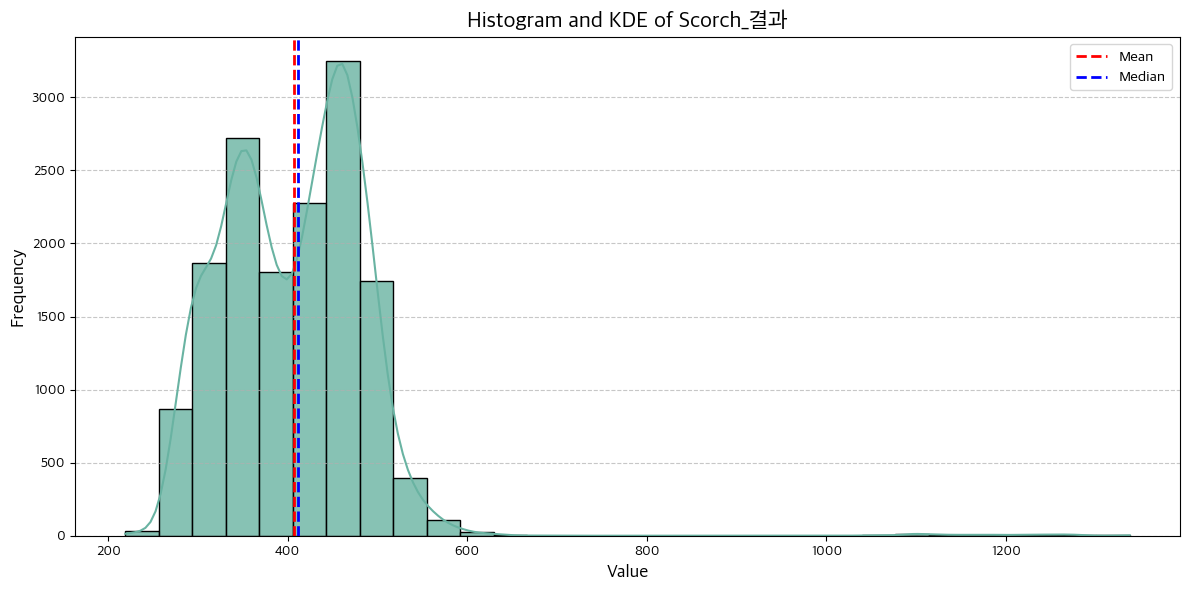

In [10]:
### Get Normal Distribution 
feature = 'Scorch_결과'
feature_normal_distribution(dataset, feature) 

## ***MODELLING***
---

In [13]:
### Train Test Split 
# Targets 
targets = ['cycle time','Ct 90_결과','Scorch_결과','Vm_결과','경도_결과']

# Cycle Time 
cycle_train_dataset, cycle_test_dataset, cycle_scaler, cycle_scaler_cols = create_train_test_dataset(dataset, targets[0], p_type)

# CT90 
ct_train_dataset, ct_test_dataset, ct_scaler, ct_scaler_cols = create_train_test_dataset(dataset, targets[1], p_type)

# Scorch
sc_train_dataset, sc_test_dataset, sc_scaler, sc_scaler_cols = create_train_test_dataset(dataset, targets[2], p_type)

# Vm 
vm_train_dataset, vm_test_dataset, vm_scaler, vm_scaler_cols = create_train_test_dataset(dataset, targets[3], p_type)

# Hard 
hard_train_dataset, hard_test_dataset, hard_scaler, hard_scaler_cols = create_train_test_dataset(dataset, targets[4], p_type)

# Print 
print('='*100)
print(f"{'cycle time':<21} | {len(cycle_train_dataset):>14,} | {len(cycle_test_dataset):>13,}")
print(f"{'Ct 90_결과':<20} | {len(ct_train_dataset):>14,} | {len(ct_test_dataset):>13,}")
print(f"{'Scorch_결과':<20} | {len(sc_train_dataset):>14,} | {len(sc_test_dataset):>13,}")
print(f"{'Vm_결과':<20} | {len(vm_train_dataset):>14,} | {len(vm_test_dataset):>13,}")
print(f"{'경도_결과':<19} | {len(hard_train_dataset):>14,} | {len(hard_test_dataset):>13,}") 
print("="*100) 

cycle time            |          9,851 |         2,311
Ct 90_결과             |          4,713 |         1,106
Scorch_결과            |          9,851 |         2,311
Vm_결과                |          9,851 |         2,311
경도_결과               |          5,849 |         1,372


In [ ]:
### Modelling - Linear 

[I 2025-10-28 14:23:59,658] A new study created in memory with name: no-name-4254ba44-c6f0-49ff-9255-172a1641e45c


학습할 Tree Features: 22 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature', 'Scorch_feature', 'Cluster']
학습 Tree 데이터 수: 9851


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-28 14:24:01,582] Trial 0 finished with value: 3.5231008495291958 and parameters: {'n_estimators': 2239, 'max_depth': 12, 'learning_rate': 0.033992323742370385, 'subsample': 0.8803874368845089, 'gamma': 0.4425570306316701, 'reg_lambda': 1.048189863620439}. Best is trial 0 with value: 3.5231008495291958.
[I 2025-10-28 14:24:02,697] Trial 1 finished with value: 3.442627635982358 and parameters: {'n_estimators': 585, 'max_depth': 7, 'learning_rate': 0.00729265520045819, 'subsample': 0.8340642819744571, 'gamma': 0.09215640260665586, 'reg_lambda': 0.0020662304366031057}. Best is trial 1 with value: 3.442627635982358.
[I 2025-10-28 14:24:04,504] Trial 2 finished with value: 7.453378894285084 and parameters: {'n_estimators': 1002, 'max_depth': 7, 'learning_rate': 0.0015680902894868206, 'subsample': 0.7340794096672686, 'gamma': 0.37661346448614996, 'reg_lambda': 0.7207455259983439}. Best is trial 1 with value: 3.442627635982358.
[I 2025-10-28 14:24:10,590] Trial 3 finished with value

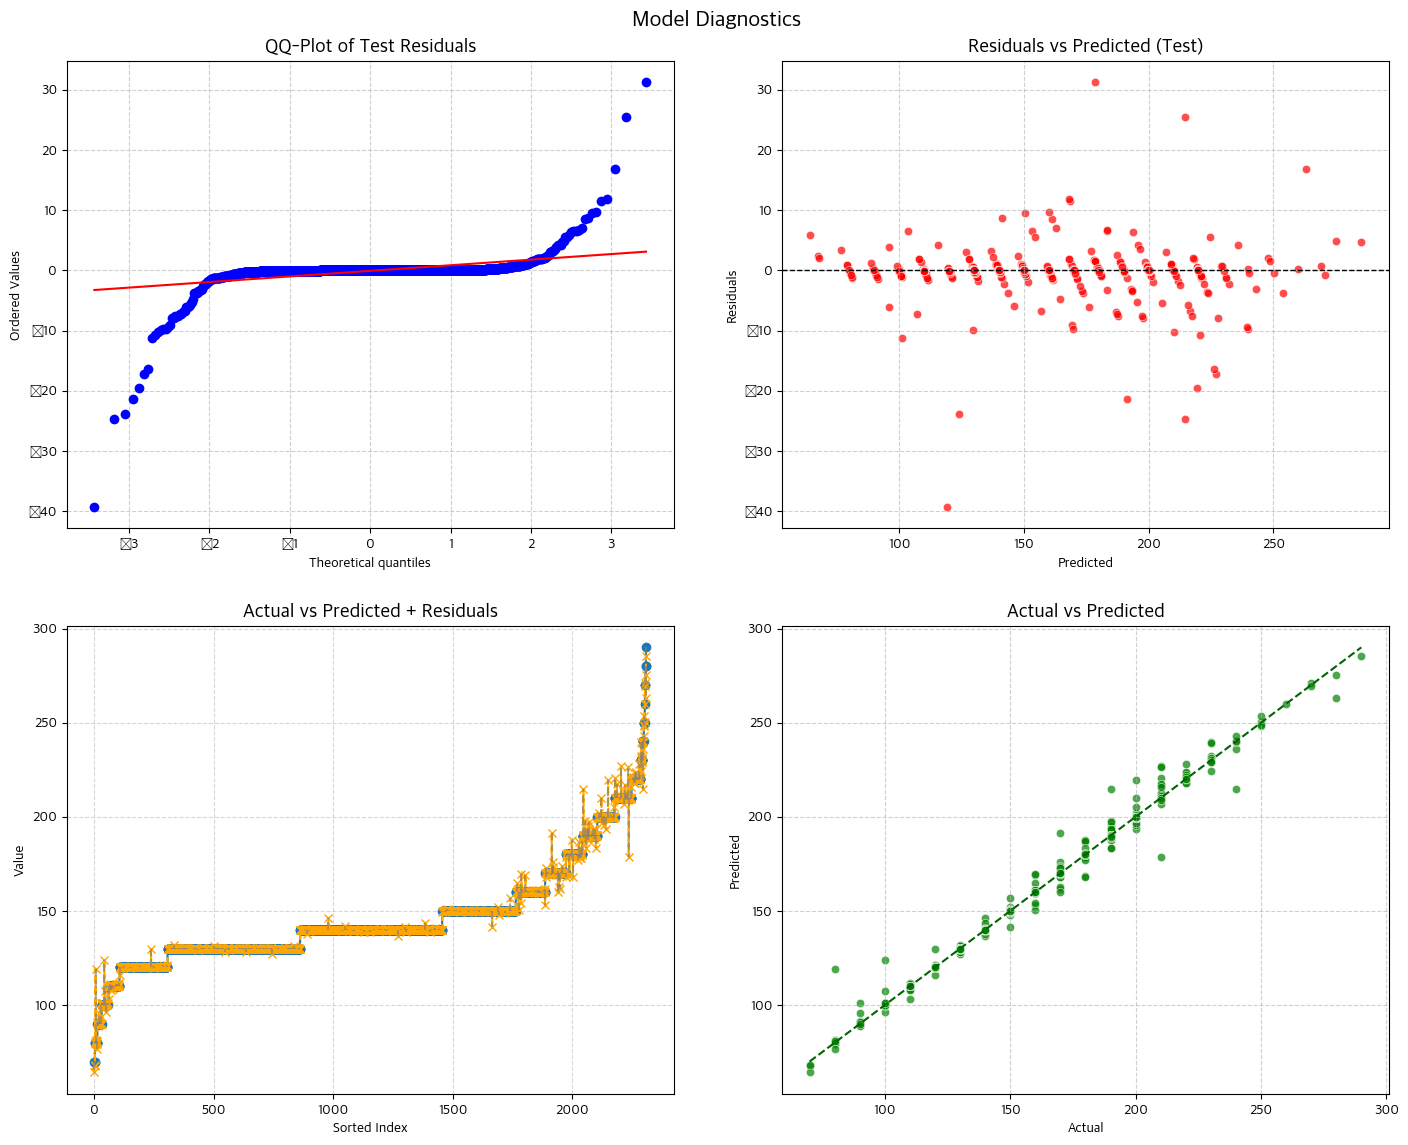

[I 2025-10-28 14:24:31,232] A new study created in memory with name: no-name-ff75fbfd-e6af-4076-a728-2867628e8bd4


Train Accuracy
Train RMSE : 0.180
Train R2   : 1.000
Train SMAPE : 0.05
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.988
Test R2   : 0.995
Test SMAPE : 0.24
학습할 Tree Features: 22 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature', 'Scorch_feature', 'Cluster']
학습 Tree 데이터 수: 4713


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-28 14:24:33,385] Trial 0 finished with value: 8.820603679983243 and parameters: {'n_estimators': 1110, 'max_depth': 7, 'learning_rate': 0.004661634361223385, 'subsample': 0.7435481950178183, 'gamma': 0.45729902321721244, 'reg_lambda': 0.0014926260145509687}. Best is trial 0 with value: 8.820603679983243.
[I 2025-10-28 14:24:35,611] Trial 1 finished with value: 8.604827078033615 and parameters: {'n_estimators': 2380, 'max_depth': 9, 'learning_rate': 0.03799332084216932, 'subsample': 0.9304475745719876, 'gamma': 0.25764571829215666, 'reg_lambda': 0.02670411376329054}. Best is trial 1 with value: 8.604827078033615.
[I 2025-10-28 14:24:40,206] Trial 2 finished with value: 8.640209347676922 and parameters: {'n_estimators': 1216, 'max_depth': 10, 'learning_rate': 0.014646259927796734, 'subsample': 0.7417461631357972, 'gamma': 0.006333389646994425, 'reg_lambda': 0.11777525605916868}. Best is trial 1 with value: 8.604827078033615.
[I 2025-10-28 14:24:41,338] Trial 3 finished with va

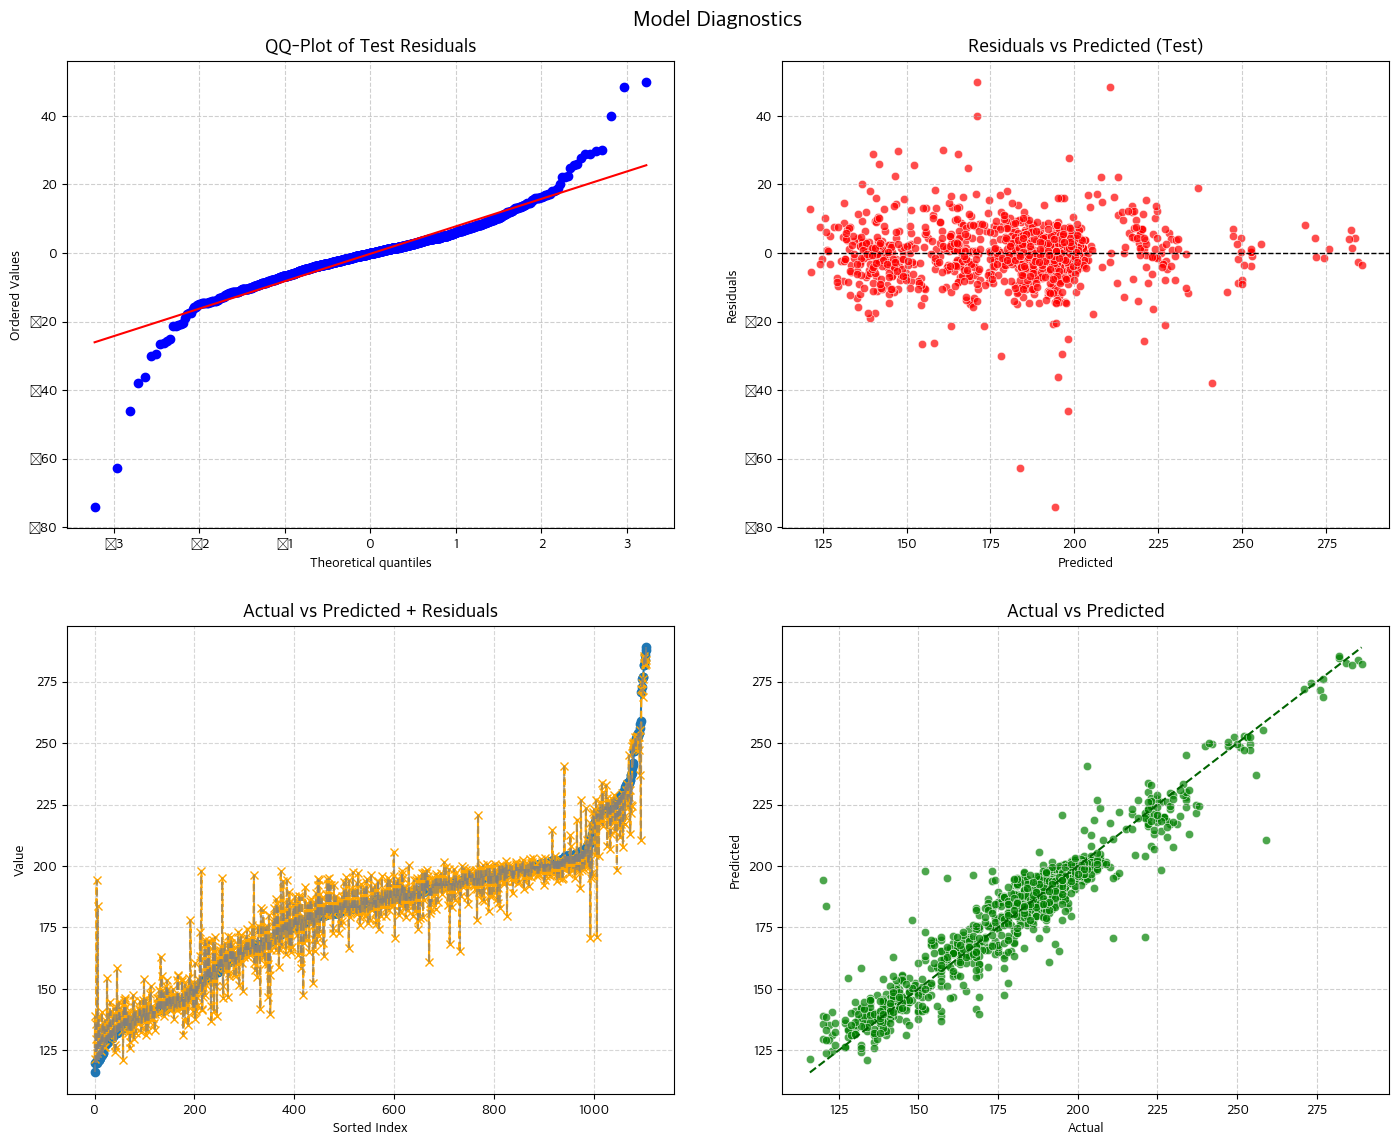

[I 2025-10-28 14:25:04,132] A new study created in memory with name: no-name-79a20c4d-0560-4a0f-abf2-dd092c6888f0


Train Accuracy
Train RMSE : 3.736
Train R2   : 0.984
Train SMAPE : 1.64
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 8.473
Test R2   : 0.914
Test SMAPE : 3.25
학습할 Tree Features: 22 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature', 'Scorch_feature', 'Cluster']
학습 Tree 데이터 수: 9851


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-28 14:25:05,523] Trial 0 finished with value: 63.45400206548162 and parameters: {'n_estimators': 301, 'max_depth': 11, 'learning_rate': 0.0014741772830166118, 'subsample': 0.7741750500684732, 'gamma': 0.1087565273651776, 'reg_lambda': 2.018009020250265}. Best is trial 0 with value: 63.45400206548162.
[I 2025-10-28 14:25:07,612] Trial 1 finished with value: 26.404699456964025 and parameters: {'n_estimators': 2176, 'max_depth': 11, 'learning_rate': 0.12330340644586332, 'subsample': 0.7805942353388694, 'gamma': 0.23165440561366307, 'reg_lambda': 0.37790043180709404}. Best is trial 1 with value: 26.404699456964025.
[I 2025-10-28 14:25:11,189] Trial 2 finished with value: 25.816342025364822 and parameters: {'n_estimators': 1909, 'max_depth': 7, 'learning_rate': 0.02054174165946274, 'subsample': 0.777929773264617, 'gamma': 0.2340167569757381, 'reg_lambda': 0.031030961176120933}. Best is trial 2 with value: 25.816342025364822.
[I 2025-10-28 14:25:12,968] Trial 3 finished with value

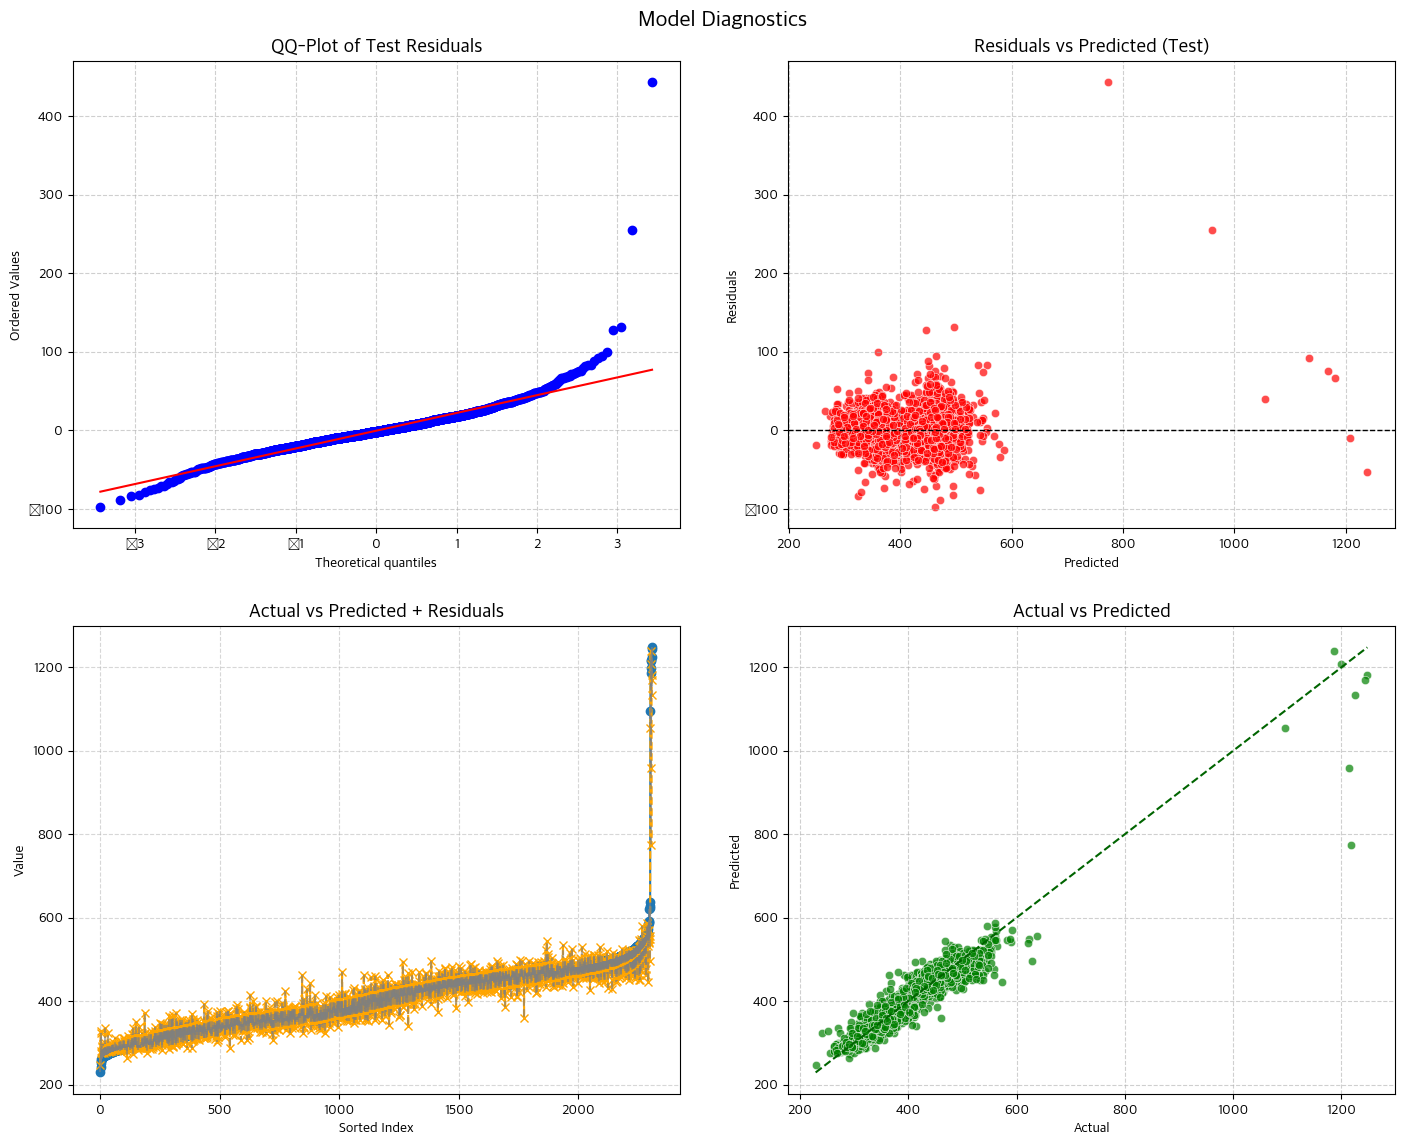

[I 2025-10-28 14:25:56,856] A new study created in memory with name: no-name-b05d9c57-facd-4dc6-95f5-fcef806e737f


Train Accuracy
Train RMSE : 2.599
Train R2   : 0.999
Train SMAPE : 0.43
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 24.445
Test R2   : 0.917
Test SMAPE : 4.09
학습할 Tree Features: 22 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature', 'Scorch_feature', 'Cluster']
학습 Tree 데이터 수: 9851


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-28 14:25:57,338] Trial 0 finished with value: 1.589596873384912 and parameters: {'n_estimators': 505, 'max_depth': 6, 'learning_rate': 0.2367792792587251, 'subsample': 0.7509980833536035, 'gamma': 0.4250396238153505, 'reg_lambda': 0.26325681513446575}. Best is trial 0 with value: 1.589596873384912.
[I 2025-10-28 14:25:58,739] Trial 1 finished with value: 1.5866543024219748 and parameters: {'n_estimators': 2350, 'max_depth': 9, 'learning_rate': 0.06874814198391282, 'subsample': 0.9531457130092416, 'gamma': 0.40625092987348843, 'reg_lambda': 0.022913133036920674}. Best is trial 1 with value: 1.5866543024219748.
[I 2025-10-28 14:25:59,217] Trial 2 finished with value: 1.6231321303073516 and parameters: {'n_estimators': 602, 'max_depth': 8, 'learning_rate': 0.23108299035622043, 'subsample': 0.8267725841014538, 'gamma': 0.27177472143664394, 'reg_lambda': 0.001718256134387859}. Best is trial 1 with value: 1.5866543024219748.
[I 2025-10-28 14:26:00,585] Trial 3 finished with value:

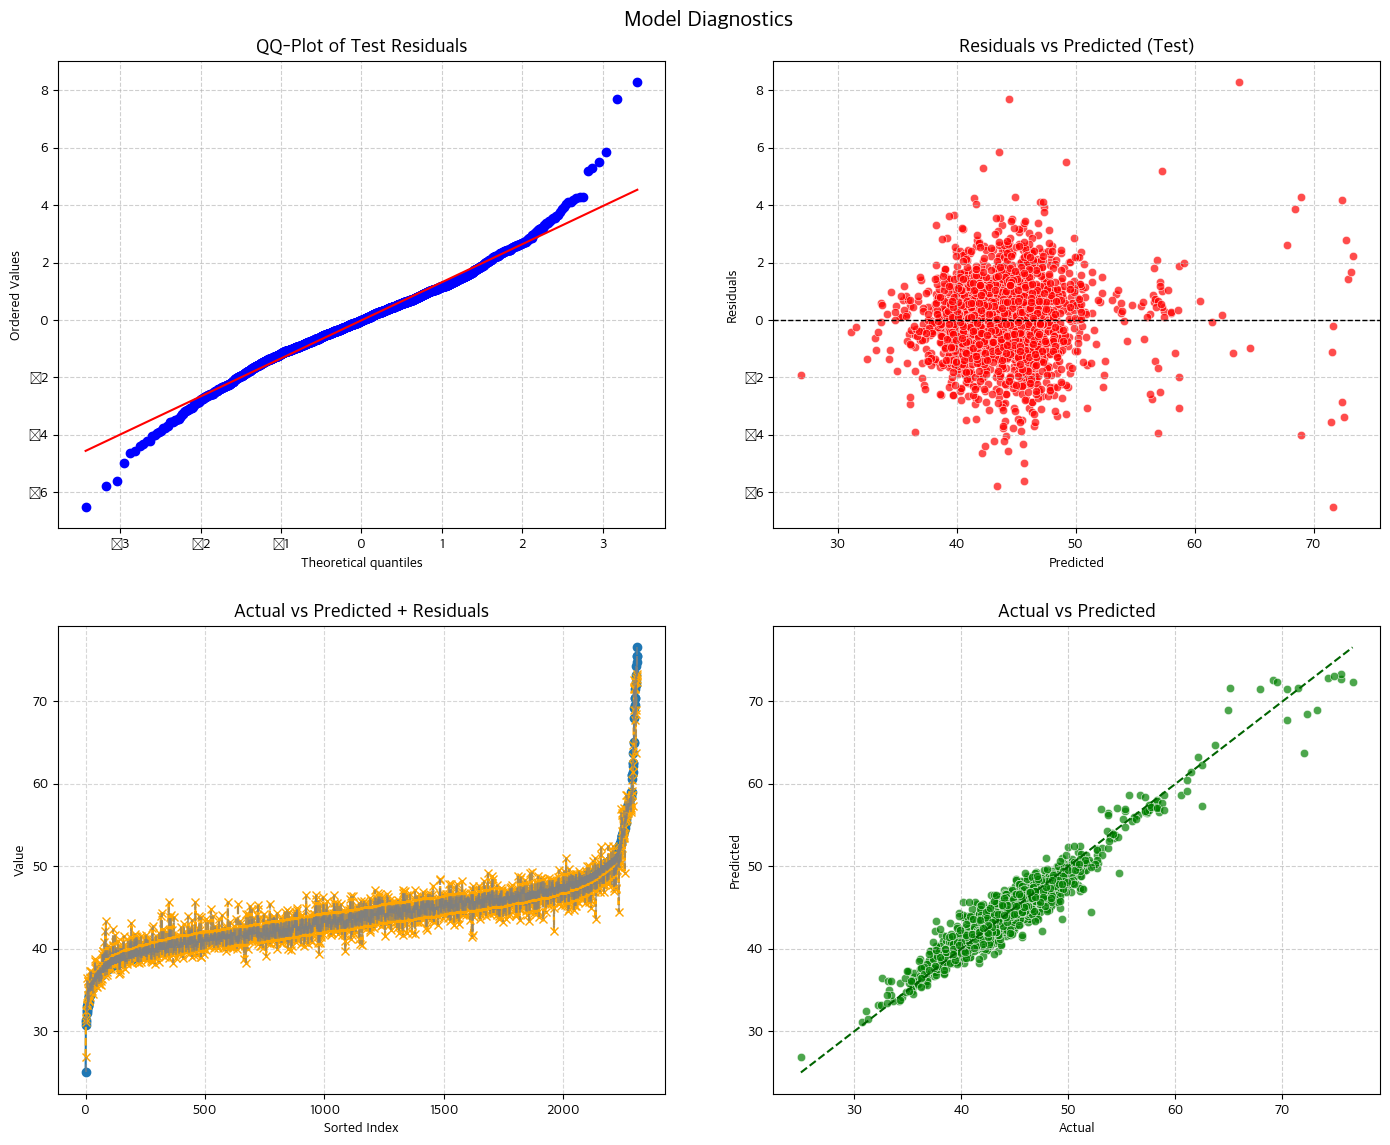

[I 2025-10-28 14:26:18,008] A new study created in memory with name: no-name-cdf560b6-c89f-411e-8cea-f89142a03ebc


Train Accuracy
Train RMSE : 0.289
Train R2   : 0.996
Train SMAPE : 0.50
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.337
Test R2   : 0.917
Test SMAPE : 2.28
학습할 Tree Features: 22 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature', 'Scorch_feature', 'Cluster']
학습 Tree 데이터 수: 5849


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-28 14:26:18,672] Trial 0 finished with value: 1.3085108895878403 and parameters: {'n_estimators': 688, 'max_depth': 6, 'learning_rate': 0.13863965603385756, 'subsample': 0.7135046665393022, 'gamma': 0.1619522944220016, 'reg_lambda': 0.002032426315701322}. Best is trial 0 with value: 1.3085108895878403.
[I 2025-10-28 14:26:21,160] Trial 1 finished with value: 1.2960297949133741 and parameters: {'n_estimators': 1440, 'max_depth': 7, 'learning_rate': 0.0023455179471972188, 'subsample': 0.9554822143534665, 'gamma': 0.34758105387725396, 'reg_lambda': 0.10231971315953178}. Best is trial 1 with value: 1.2960297949133741.
[I 2025-10-28 14:26:23,602] Trial 2 finished with value: 1.2723044126072458 and parameters: {'n_estimators': 2323, 'max_depth': 7, 'learning_rate': 0.02598303280011908, 'subsample': 0.9827362492661085, 'gamma': 0.033900957791446806, 'reg_lambda': 0.11870527108100218}. Best is trial 2 with value: 1.2723044126072458.
[I 2025-10-28 14:26:24,743] Trial 3 finished with 

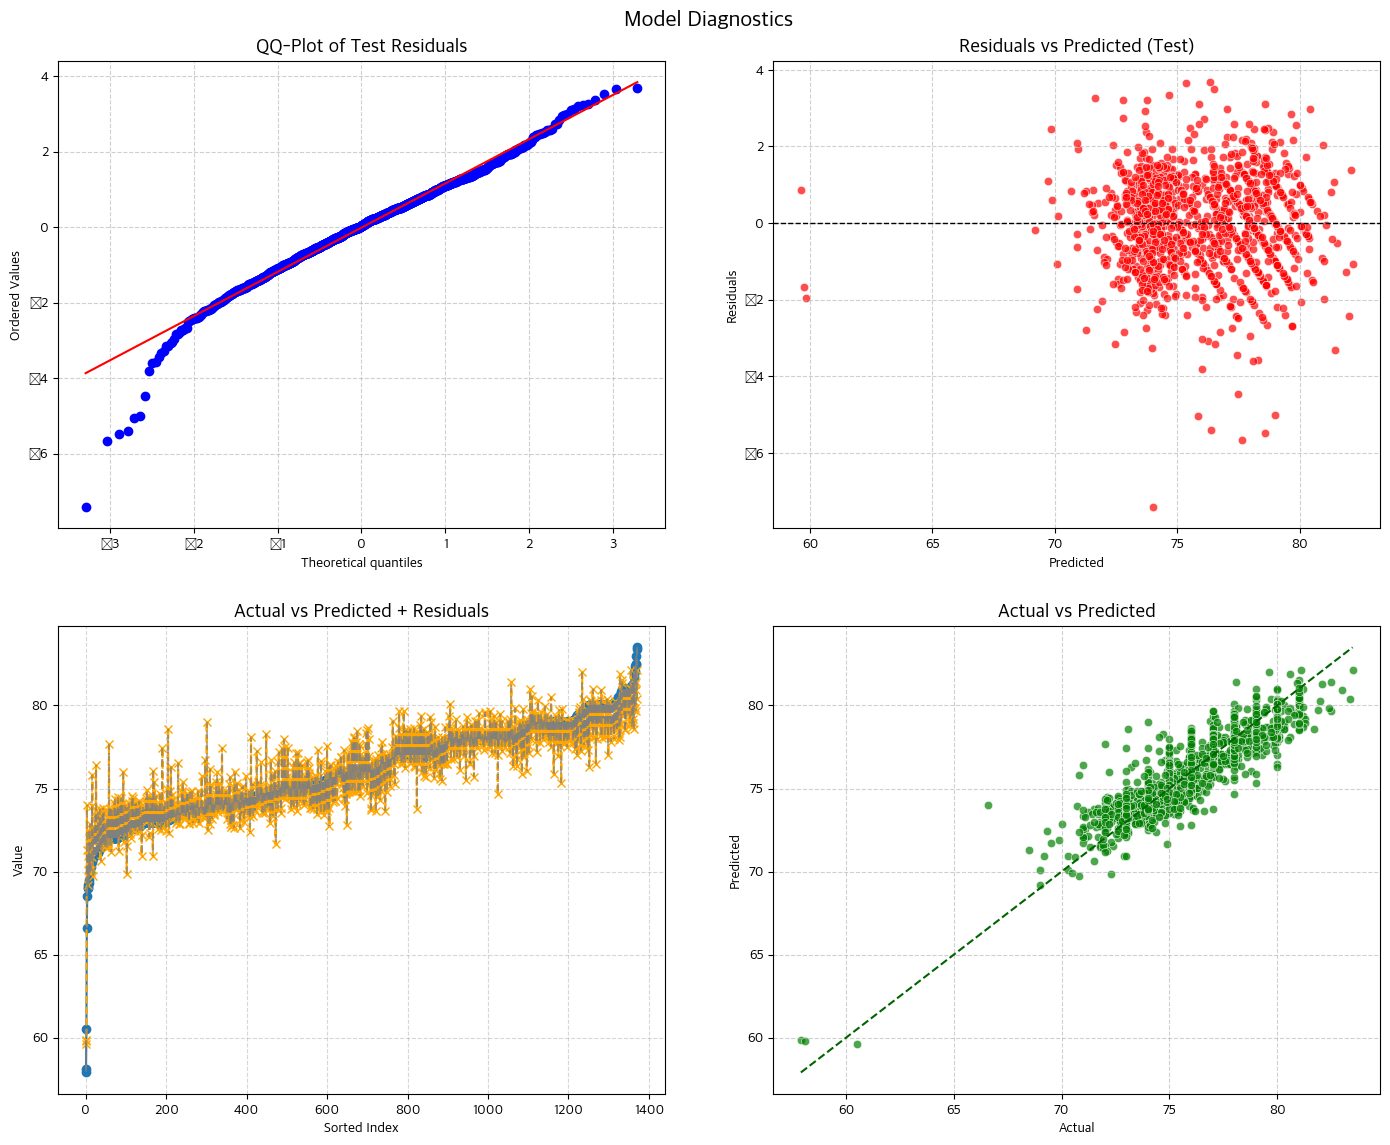

Train Accuracy
Train RMSE : 0.334
Train R2   : 0.985
Train SMAPE : 0.35
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.184
Test R2   : 0.814
Test SMAPE : 1.19


In [ ]:
### Modelling - XGBoost 
# Cycle Time 
cycle_model, cycle_importance = train_tree(cycle_train_dataset, cycle_test_dataset, target_col='cycle time')

# CT90 
ct_model, ct_importance = train_tree(ct_train_dataset, ct_test_dataset, target_col='Ct 90_결과')

# Scorch 
sc_model, sc_importance = train_tree(sc_train_dataset, sc_test_dataset, target_col='Scorch_결과')

# Vm 
vm_model, vm_importance = train_tree(vm_train_dataset, vm_test_dataset, target_col='Vm_결과')

# Hard 
hard_model, hard_importance = train_tree(hard_train_dataset, hard_test_dataset, target_col='경도_결과') 